# Introduction:
This project investigates the difference between EUGENe's existing models deepbind and kopp21_cnn. The main difference between these two models is the type of loss function used. Deepbind uses the standard mean square error loss function while kopp21_cnn uses a binary cross entropy scheme. Listed below are the main parameters of the files used in this project as well as the parameters of the hybrid file used in previous projects.

1. hybrid.yaml
    *   input length = 170
    *   output dimension = 1
    *   task = regression
    *   loss function = Mean Squared Error (MSE)

2. deepbind.yaml
    *   input length = 41
    *   output dimension = 1
    *   task = regression
    *   loss function = MSE

3. kopp21_cnn.yaml
    *   input length = 500
    *   output dimension = 1
    *   task = regression
    *   loss function = BCE

# Augmentation
To standardize our testing, we are going to change all of the models to have the same input length as the hybrid model, input length = 170. This will allow us to investigate the differences in model outcomes between regression via mean squared error and regression via binary cross entropy as all other paramters will be relatively the same.

The major difference between these two loss fucntions is how they change the weights of each node during stochastic gradient descent. MSE has a smaller effect on the weights when the input incorrectly macthes to an output during training while BCE imposes a harsh penalty ie: changed the weight by a proportionally large amount. The following derivation with an example is shown below:

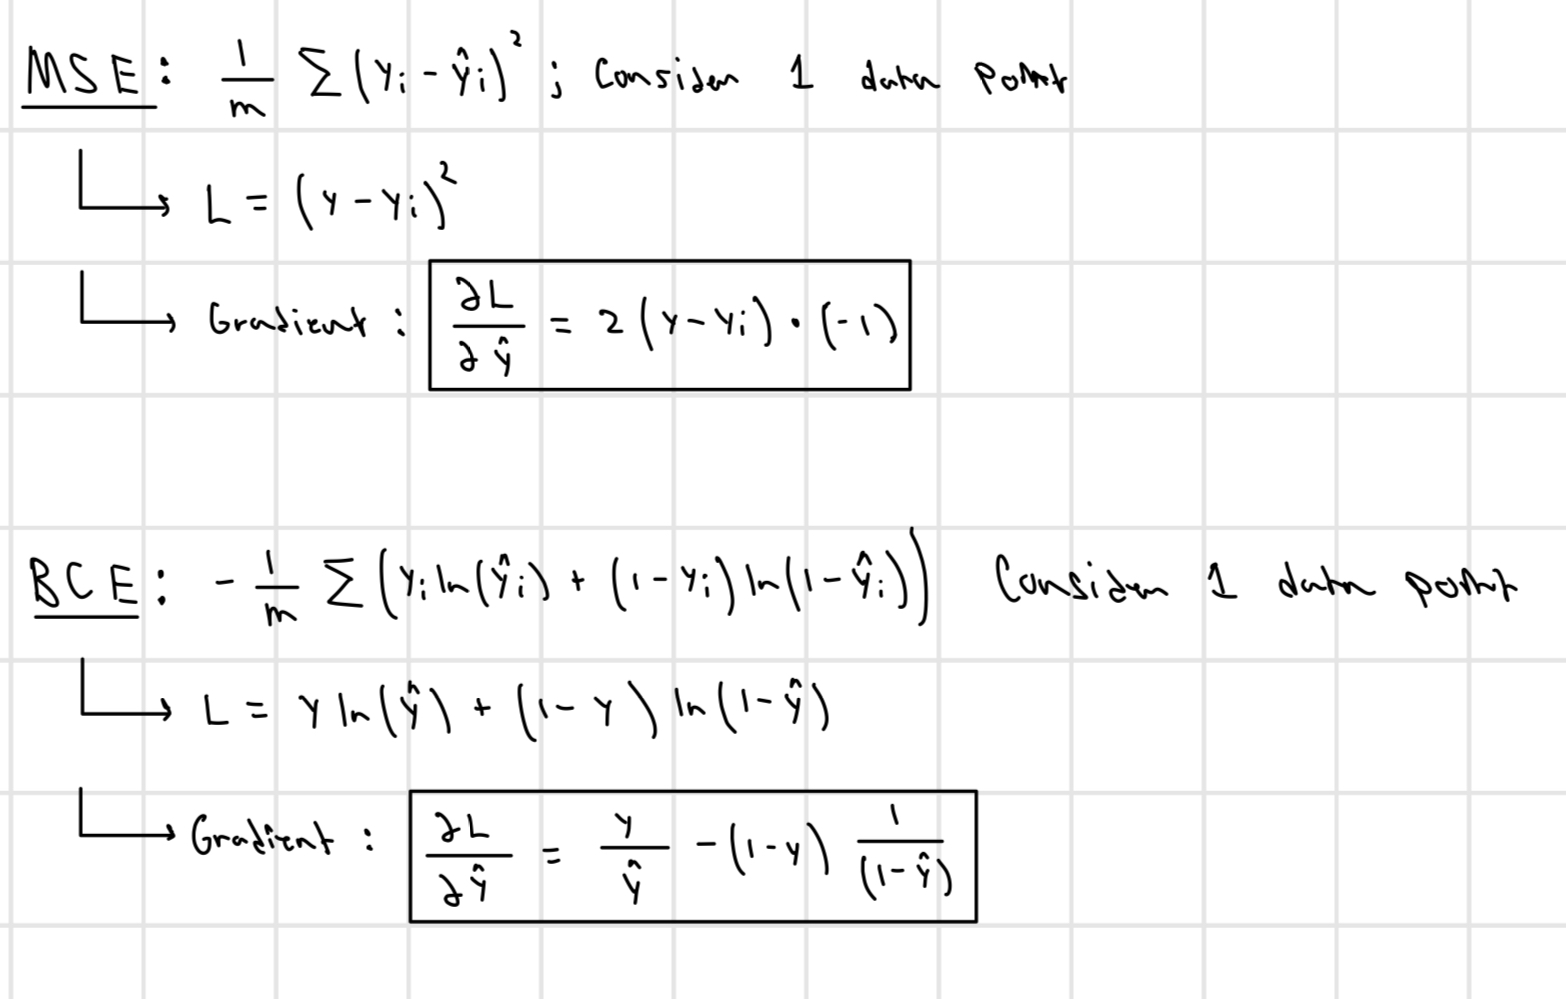

# Hypothesis
Given that the gradient adjustment when a wrong prediction is made is much larger for BCE than MSE, it can be hypothesized that BCE models will be more accurate than MSE models. This hypothesis will be investigated by looking at the loss functions of each model as well as the scatter plot of predicted vs ground truth values. This will be completed by looking at the R^2, spearman, pearson and MSE of both graphs.


In [ ]:
# install relavent packages, environments, modules and link drive
!pip install virtualenv
!pip install seqdatasets
!pip install "eugene-tools"

from eugene import settings
import seqdatasets
from eugene import plot as pl
from eugene import preprocess as pp
from eugene import models
from eugene import train
import os
from eugene import interpret
from eugene import evaluate
import glob
import seqpro as sp
import xarray as xr
import motifdata as md
from google.colab import drive

drive.mount("/content/drive")

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


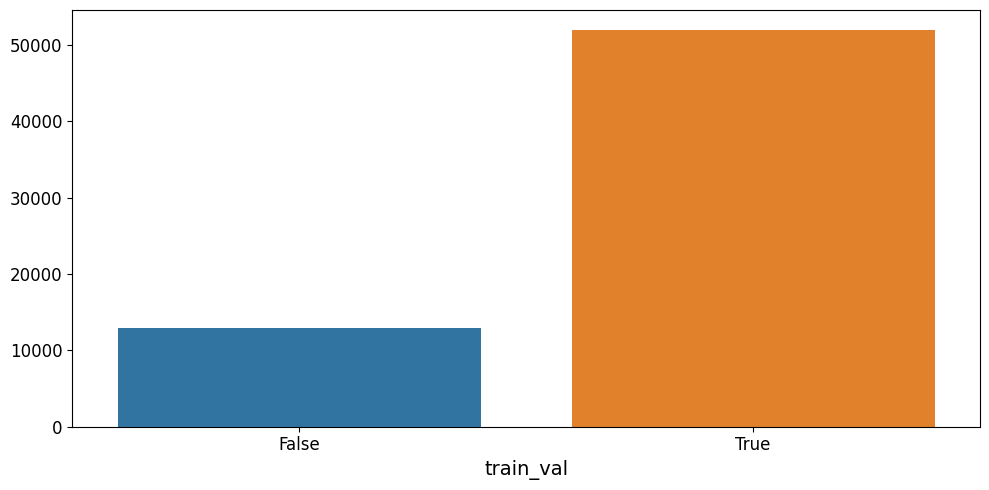

In [4]:

# Specify where outputs, models and data will be stored
settings.config_dir = "outputs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "outputs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "outputs" # Directory where EUGENe will save output files to
settings.figure_dir = "outputs" # Directory to specify to EUGENe to save figures to

# get data previously used data set
seqdatasets.get_dataset_info()
sdata = seqdatasets.jores21(dataset="leaf")
sdata

# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

# Split the training set into training and validation - 20% training
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

# Check the split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")

In [18]:
# load model 1
model_1 = models.load_config("/deepbind.yaml")
model_1.summary()


Model: DeepBind
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: None
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type     | Params | Mode 
--------------------------------------------------
0 | arch         | DeepBind | 2.1 K  | train
1 | train_metric | R2Score  | 0      | train
2 | val_metric   | R2Score  | 0      | train
3 | test_metric  | R2Score  | 0      | train
--------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode

In [43]:
# load model 2
model_2 = models.load_config("/kopp21_cnn.yaml")
model_2.summary()

Model: Kopp21CNN
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: binary_cross_entropy_with_logits
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type      | Params | Mode 
---------------------------------------------------
0 | arch         | Kopp21CNN | 743    | train
1 | train_metric | R2Score   | 0      | train
2 | val_metric   | R2Score   | 0      | train
3 | test_metric  | R2Score   | 0      | train
---------------------------------------------------
743       Trainable params
0         Non-trainable params
743       Total params
0.003     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/eugene_logs/deepbind/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type     | Params | Mode 
--------------------------------------------------
0 | arch         | DeepBind | 2.1 K  | train
1 | train_metric | R2Score  | 0      | train
2 | val_metric   | R2Score  | 0      | train
3 | test_metric  | R2Score  | 0      | train
--------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

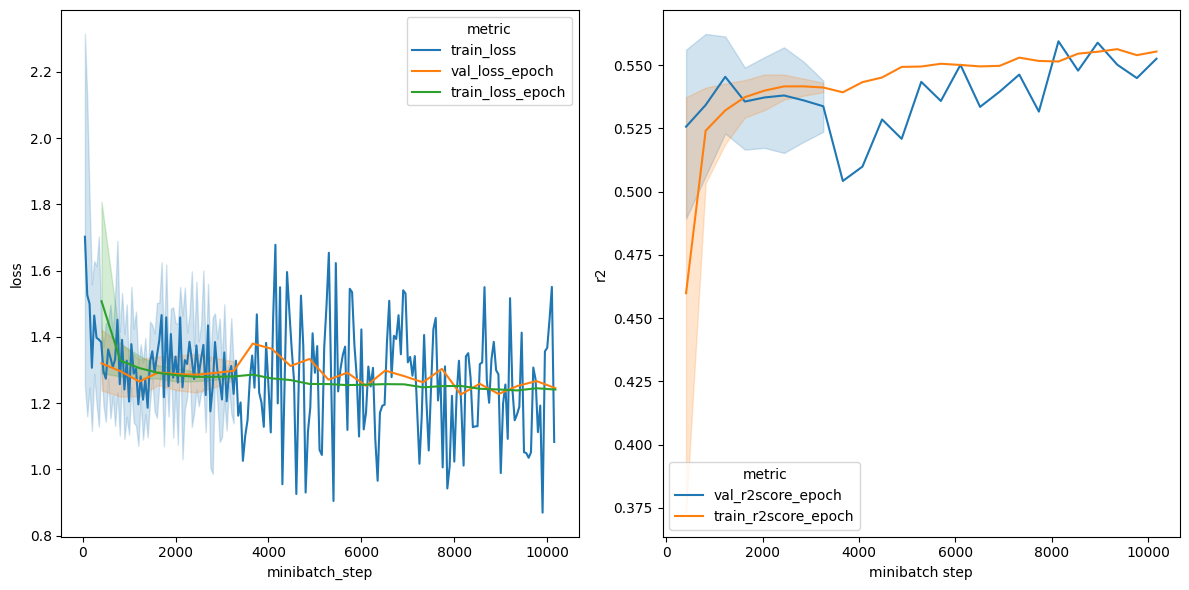

In [19]:
# train data on deepbind

train.fit_sequence_module(
    model=model_1,
    sdata = sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=30,
    gpus=1,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="deepbind",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "deepbind", "tutorial_model"), metric="r2")

## Evaluation

model_file_1 = glob.glob(os.path.join(settings.logging_dir, "deepbind", "tutorial_model", "checkpoints", "*"))[0]
best_model_1 = models.SequenceModule.load_from_checkpoint(model_file_1, arch=model_1.arch)

evaluate.predictions_sequence_module(
    best_model_1,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    in_memory=True,
    name="deepbind",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.34531961967711666 0.9118619507939644 0.627845958104308
Sb 0.5693806284254868 1.1691393030386135 0.7743678725317589
Zm 0.5700316455323531 1.3091876925117505 0.780384432017978


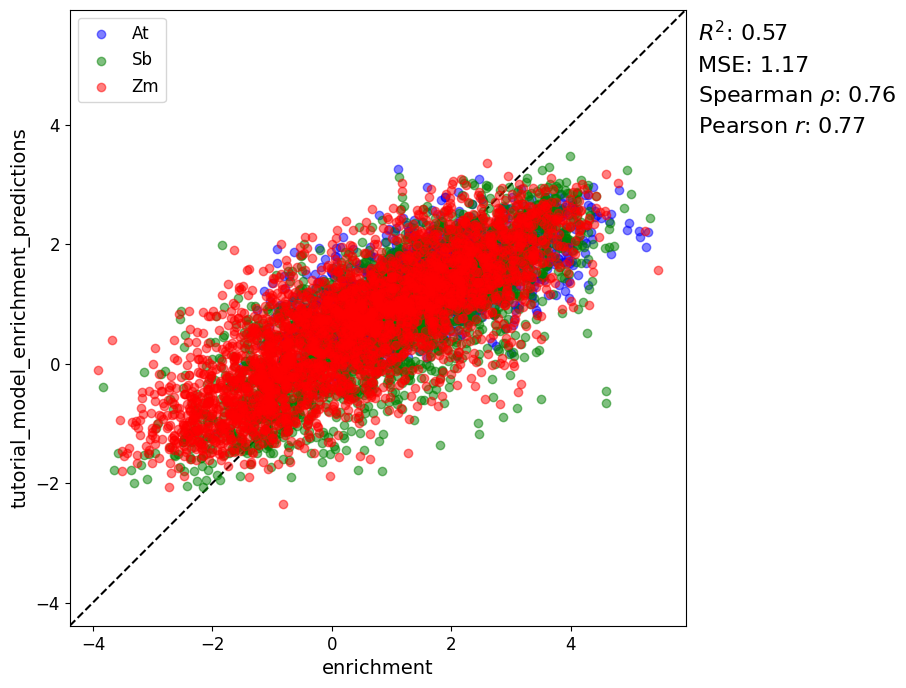

In [20]:
# plot performance scatter
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

In [45]:
# train data on kopp21_cnn
train.fit_sequence_module(
    model=model_2,
    sdata = sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=30,
    gpus=1,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="kopp21_cnn",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/eugene_logs/kopp21_cnn/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

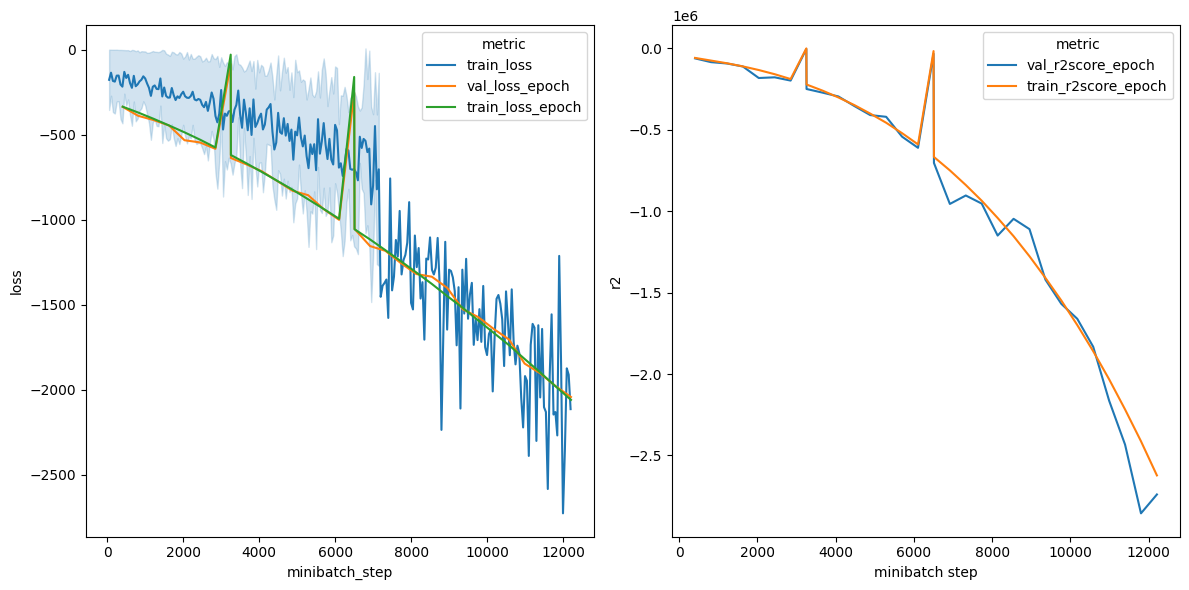

In [47]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "kopp21_cnn", "tutorial_model"), metric="r2")

## Evaluation
model_file_2 = glob.glob(os.path.join(settings.logging_dir, "kopp21_cnn", "tutorial_model", "checkpoints", "*"))[0]
best_model_2 = models.SequenceModule.load_from_checkpoint(model_file_2, arch=model_2.arch)

evaluate.predictions_sequence_module(
    best_model_2,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    in_memory=True,
    name="kopp21_cnn",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At -80068.46547503378 111523.57880510362 0.5589090563579806
Sb -34181.11243638436 92805.0472140609 0.728134838272167
Zm -27826.03095506186 84729.04125843458 0.722547152834161


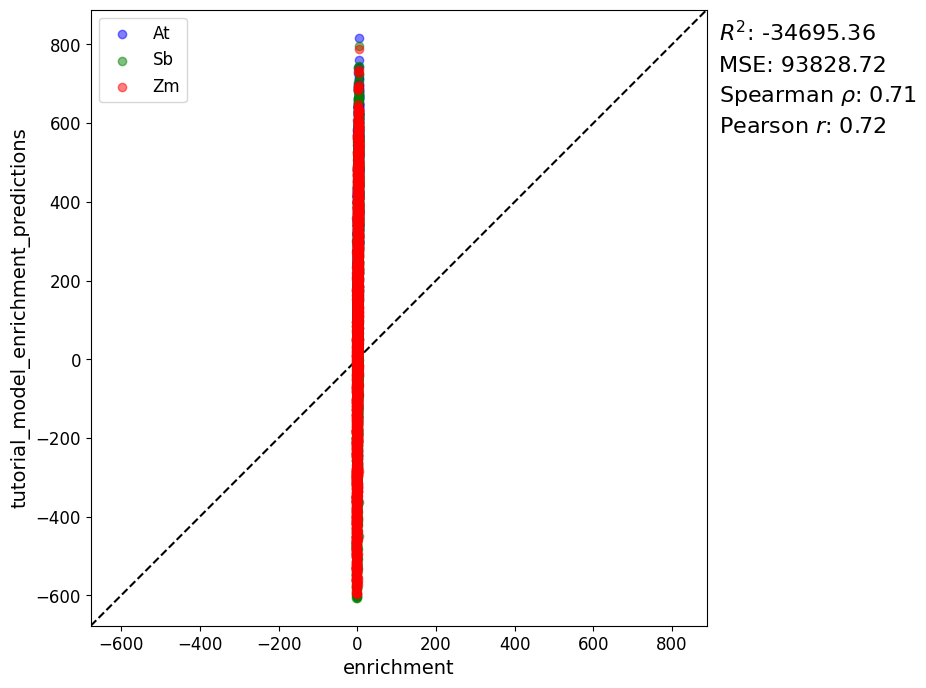

In [48]:
# plot kopp21_cnn scatter
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

# Conclusion
The binary cross entropy model results invalidate the original hypothesis that the BCE model woul produce more accurate results than the MSE model. This is most likely caused by the gradient descent changes being to large where after training, the predicted output are far off from the actual data. Another theory may be because of the application of the BCE on this specific dataset. The original kopp21_cnn was used for binary classificating and was changed to be used for regression in order to suceessfully load the model. This dataset does not contain binary data. Although the application of BCE was used incorrectly, it was educational to learn the math behind this model. and see the outcome from a different neural network.

The deepbind model sucessfully trained and predicted outcomes from the data set without overtraining the model. It is important to note that this model functioned less sucessfully (based on the statistics) but the results are most likely to be accurate. This is because of the lack of overtrainig.